### Code from asian_fixed_ML (trying to get density_estimation(), but not working yet)

In [6]:
import qmcpy as qp
from qmcpy import *
import numpy as np
import math
import pandas as pd
from pandas import *
import math as math
import scipy as sc
from sympy import *
pd.options.display.float_format = '{:.2e}'.format
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from scipy.stats import norm
from qmcpy.discrete_distribution._discrete_distribution import LD
from qmcpy.accumulate_data import MLQMCData
from qmcpy.integrand import  MLCallOptions
import time as t
from scipy.special import erf
from qmcpy.integrand import Integrand
from qmcpy.discrete_distribution import DigitalNetB2
from qmcpy.true_measure import Gaussian
from qmcpy.util import ParameterError, MaxSamplesWarning, ParameterError, MaxLevelsWarning
import warnings
import array
from numpy.linalg import lstsq
from qmcpy.accumulate_data import AccumulateData

In [7]:
level_dims = [2,4,8]
ac2_multilevel = AsianOption(DigitalNetB2(seed=7),multilevel_dims=level_dims)
levels_to_spawn = np.arange(ac2_multilevel.max_level+1)
ac2_single_levels = ac2_multilevel.spawn(levels_to_spawn)
yml = 0
for ac2_single_level in ac2_single_levels:
    x = ac2_single_level.discrete_distrib.gen_samples(2**12)
    level_est = ac2_single_level.f(x).mean()
    yml += level_est
yml

1.7798714253755274

In [8]:
class FMLAsianOption(Integrand):

    def __init__(self, sampler, volatility=.2, option='asian', start_price=100.,
        strike_price=100., interest_rate=.05, t_final=1., _level=0, 
                 call_put='call', mean_type='arithmetic', multilevel_dims=[4,16,64]):
        
        self.ac2_multilevel = AsianOption(sampler, multilevel_dims=multilevel_dims, volatility=volatility, option=option, start_price=start_price,
        strike_price=strike_price, interest_rate=interest_rate, t_final=t_final, _level=_level, 
                 call_put=call_put, mean_type=mean_type)
        
        super(FMLAsianOption,self).__init__(dimension_indv=len(multilevel_dims),dimension_comb=1,parallel=False) # super = inhereting
    
    def g(self, t, *args):
        y=np.zeros((len(t), self.t_indv))
        for k in range (self.d_indv):
            d=self.ac2_multilevel[k].true_measure.d
            y[:,k]=self.ac2_multilevel[k].g(t[:,])

In [4]:
seed = 7

### Code from density_estimation: 

In [11]:
class RQMCEstimator:
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol'):
        #self.g=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
        self.n=n # number of paths (Quasi-monte carlo samples)
        self.h=h # bandwidth
        self.k=k # kernel
        if sequence=='Sobol':
            self.sampler=Sobol(1).gen_samples(n)
            
        elif sequence=='Lattice':
            self.sampler=Lattice(1).gen_samples(n)
            
        else:
            raise ValueError("Invalid input. Must be Sobol or Lattice")  
    
    def mise(self):
        est=np.squeeze(self.density_estimation())
        real_distrib=self.gaussian(self.points,2, 1) # we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise
    
    
    
class OptionEstimator(RQMCEstimator): # inherets from RQMCEstimator class above
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol', K=30, S0=50, T=1,
                 option='EPO'):
        # T = maturity time (in years)
        # K = spike price (stock price at maturity time)
        # r = interest rate (reflects inflation)
        # Sigma = volatility
        # S_0 = initial stock price

        super().__init__(n, h,k,sequence)
        self.option=option
        if option=='ECO': 
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        elif option=='EPO':
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        else:
            raise ValueError("Invalid input. Must be ECO or EPO")
        self.n=n 
        self.h=h
        self.k=k
        self.s=lambda x:self.S0*np.exp((r-sigma**2/2)*self.T+sigma*np.sqrt(self.T)*sc.stats.norm.ppf(x))
    def density_estimation(self,x):
        if self.option=='ECO':
            f=zeros(len(x),1)
            g=np.maximum(self.s(self.sampler)-self.K,0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)         
        else:
            f=zeros(len(x),1)
            g=np.maximum(self.K-self.s(self.sampler),0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)
        plt.figure()
        plt.plot(r,f2)
        plt.title("Density estimation")
        plt.xlabel("x")
        plt.ylabel("pdf")
        plt.show()
        print("Lower bound of estimation interval (a) is:",a)
        print("Upper bound of estimation interval (b) is:",b)
        return f,a,b   
    def mise(self):
        est=np.squeeze(self.density_estimation())
        real_distrib=self.gaussian(self.points,2, 1) # we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise

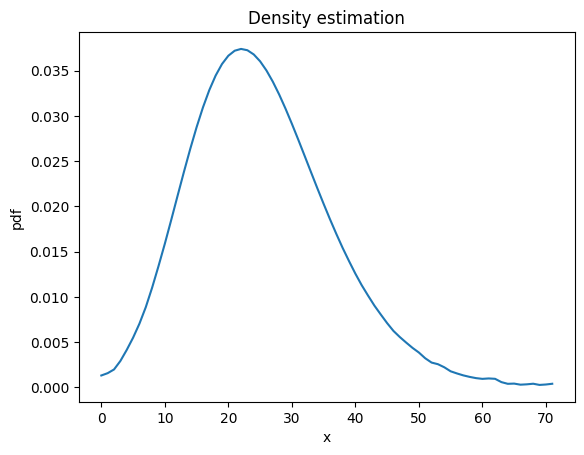

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [70.8487138]
Matrix([[0.00384078210742066]])


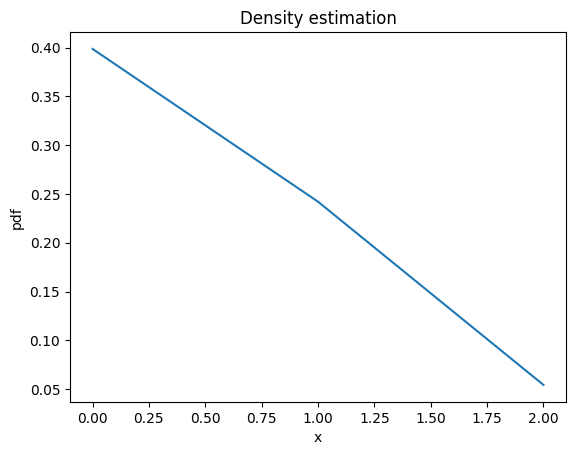

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [1.3374494]
Matrix([[0]])


In [12]:
# for this density function: partially discrete (probability of it being 0 is like 1/3, for instance), and partially continuous for any nonzero input
est=OptionEstimator(h=1, n=1024, option='ECO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x) # ECO: looks like a normal distribution, slightly skewed right, wider estimation interval
print(f[0]) 

est=OptionEstimator(h=1, n=1024, option='EPO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x) # EPO: looks like a neg-sloping line? narrower estimation interval
print(f[0])

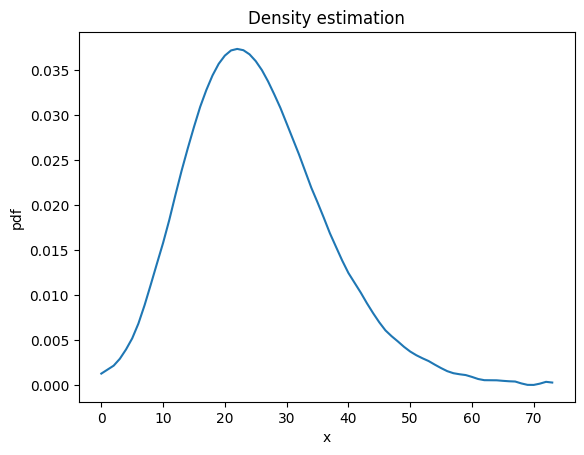

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [72.2623105]
Matrix([[0.00129254420688886], [0.00130489662187871], [0.00131708440182161], [0.00132910610441943], [0.00134096059230344], [0.00135264703319086], [0.00136416489935845], [0.00137551396643811], [0.00138669431154152], [0.00139770631072300], [0.00140855063579183], [0.00141922825048732], [0.00142974040603192], [0.00144008863607947], [0.00145027475107776], [0.00146030083206616], [0.00147016922393078], [0.00147988252814143], [0.00148944359499589], [0.00149885551539866], [0.00150812161220240], [0.00151724543114181], [0.00152623073139041], [0.00153508147577185], [0.00154380182065830], [0.00155239610558881], [0.00156086884264164], [0.00156922470559443], [0.00157746851890688], [0.00158560524656058], [0.00159363998079058], [0.00160157793074342], [0.00160942441109614], [0.00161718483067007], [0.00162486468107332], [0.00163246952540480], [0.00164000498705212], [0.00164747673861496], [0.00165489049

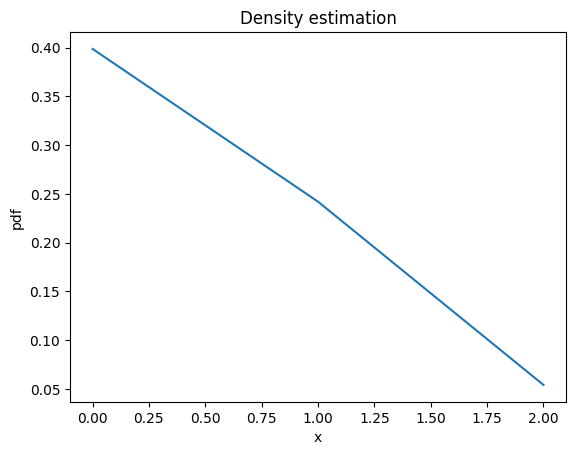

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [1.06851919]
Matrix([[0.398772821700222], [0.398694639329211], [0.398450592676185], [0.398040988671544], [0.397466340629293], [0.396727367175930], [0.395824990753784], [0.394760335702828], [0.393534725926873], [0.392149682150798], [0.390606918776810], [0.388908340348649], [0.387056037634234], [0.385052283337844], [0.382899527454079], [0.380600392277189], [0.378157667079593], [0.375574302475089], [0.372853404482319], [0.369998228305617], [0.367012171850223], [0.363898768990343], [0.360661682608306], [0.357304697424386], [0.353831712636546], [0.350246734390368], [0.346553868099293], [0.342757310635825], [0.338861342414365], [0.334870319386537], [0.330788664969754], [0.326620861929909], [0.322371444238926], [0.318044988927498], [0.313646107953600], [0.309179440106342], [0.304649642965221], [0.300061384933512], [0.295419337364891], [0.290728166801056], [0.285992527338247], [0.281217053139334], [0.276

In [14]:
est=OptionEstimator(h=1, n=1024, option='ECO')
x=np.linspace(0,1,50)
# x=[50]
f=est.density_estimation(x) # ECO: looks like a normal distribution, slightly skewed right, wider estimation interval
print(f[0]) 

est=OptionEstimator(h=1, n=1024, option='EPO')
x=np.linspace(0,1,50)
# x=[50]
f=est.density_estimation(x) # EPO: looks like a neg-sloping line? narrower estimation interval
print(f[0])

In [15]:
level=1
aco = qp.AsianOption(qp.Sobol(2*2**level, seed=seed), volatility=.2, start_price=100, strike_price=150, interest_rate=.05, call_put='put')
kde,a,b, approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-4).density_estimation()
print("European Option value: %.5f (to within 1e-4)"% approx_solution)

AttributeError: 'CubQMCSobolG' object has no attribute 'density_estimation'

# Comparison of multilevel (Quasi-)Monte Carlo for an Asian option problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/asian-option-mlqmc.ipynb)

Compute the exact value of the Asian option with single level QMC, for an increasing number of time steps:

In [3]:
for level in range(5):
    aco = qp.AsianOption(qp.Sobol(2*2**level, seed=seed), volatility=.2, start_price=100, strike_price=100, interest_rate=.05)
    approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-4).integrate()
    print("Asian Option true value (%d time steps): %.5f (to within 1e-4)"%(2*2**level, approx_solution))

Asian Option true value (2 time steps): 5.63591 (to within 1e-4)
Asian Option true value (4 time steps): 5.73171 (to within 1e-4)
Asian Option true value (8 time steps): 5.75526 (to within 1e-4)
Asian Option true value (16 time steps): 5.76113 (to within 1e-4)
Asian Option true value (32 time steps): 5.76260 (to within 1e-4)


This function compares 4 different algorithms: Multilevel Monte Carlo (`CubMCML`), Multilevel Quasi-Monte Carlo (`CubQMCML`), continuation Multilevel Monte Carlo (`CubMCMLCont`) and Multilevel Quasi-Monte Carlo (`CubQMCMLCont`):

In [4]:
def eval_option(option_mc, option_qmc, abs_tol):
    stopping_criteria = {
        "MLMC" : qp.CubMCML(option_mc, abs_tol=abs_tol, levels_max=15),
        "continuation MLMC" : qp.CubMCMLCont(option_mc, abs_tol=abs_tol, levels_max=15),
        "MLQMC" : qp.CubQMCML(option_qmc, abs_tol=abs_tol, levels_max=15),
        "continuation MLQMC" : qp.CubQMCMLCont(option_qmc, abs_tol=abs_tol, levels_max=15)
    }
    
    levels = []
    times = []
    for name, stopper in stopping_criteria.items():
        sol, data = stopper.integrate()
        levels.append(data.levels)
        times.append(data.time_integrate)
        print("\t%-20s solution %-10.4f number of levels %-6d time %.3f"%(name, sol, levels[-1], times[-1]))
        
    return levels, times

Define the Multilevel Asian options:

In [5]:
option_mc = qp.MLCallOptions(qp.IIDStdUniform(seed=seed), option="asian")
option_qmc = qp.MLCallOptions(qp.Lattice(seed=seed), option="asian")

Run and compare each of the 4 algorithms for the Asian option problem:

In [6]:
eval_option(option_mc, option_qmc, abs_tol=5e-3);

	MLMC                 solution 5.7620     number of levels 10     time 45.993
	continuation MLMC    solution 5.7580     number of levels 7      time 30.715
	MLQMC                solution 5.7606     number of levels 8      time 19.286
	continuation MLQMC   solution 5.7594     number of levels 7      time 10.107


Repeat this comparison for a sequence of decreasing tolerances, with 5 different random seeds each. This will allow us to visualize the asymptotic cost complexity of each method.

In [12]:
repetitions = 5
tolerances = 5*np.logspace(-1, -3, num=5)

levels = {}
times = {}
for t in range(len(tolerances)):
    for r in range(repetitions):
        print("tolerance = %10.4e, repetition = %d/%d"%(tolerances[t], r + 1, repetitions))
        levels[t, r], times[t, r] = eval_option(option_mc, option_qmc, tolerances[t])

tolerance = 5.0000e-01, repetition = 1/5
	MLMC                 solution 5.5049     number of levels 3      time 0.008
	continuation MLMC    solution 5.6865     number of levels 3      time 0.008
	MLQMC                solution 5.7204     number of levels 3      time 0.474
	continuation MLQMC   solution 5.7099     number of levels 3      time 0.000
tolerance = 5.0000e-01, repetition = 2/5
	MLMC                 solution 5.7316     number of levels 4      time 0.008
	continuation MLMC    solution 5.6755     number of levels 4      time 0.016
	MLQMC                solution 5.7196     number of levels 3      time 0.508
	continuation MLQMC   solution 5.7014     number of levels 3      time 0.000
tolerance = 5.0000e-01, repetition = 3/5
	MLMC                 solution 5.6791     number of levels 3      time 0.001
	continuation MLMC    solution 5.8100     number of levels 3      time 0.010
	MLQMC                solution 5.6972     number of levels 3      time 0.453
	continuation MLQMC   solution

Compute and plot the asymptotic cost complexity.

In [8]:
avg_time = {}
for method in range(4):
    avg_time[method] = [np.mean([times[t, r][method] for r in range(repetitions)]) for t in range(len(tolerances))]

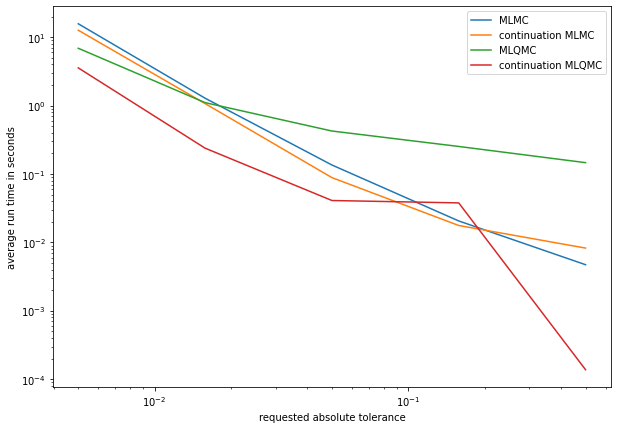

In [9]:
plt.figure(figsize=(10,7))
plt.plot(tolerances, avg_time[0], label="MLMC")
plt.plot(tolerances, avg_time[1], label="continuation MLMC")
plt.plot(tolerances, avg_time[2], label="MLQMC")
plt.plot(tolerances, avg_time[3], label="continuation MLQMC")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("requested absolute tolerance")
plt.ylabel("average run time in seconds")
plt.legend();

In [10]:
max_levels = {}
for method in range(4):
    levels_rep = np.array([levels[len(tolerances)-1, r][method] for r in range(repetitions)])
    max_levels[method] = [np.count_nonzero(levels_rep == level)/repetitions for level in range(15)]

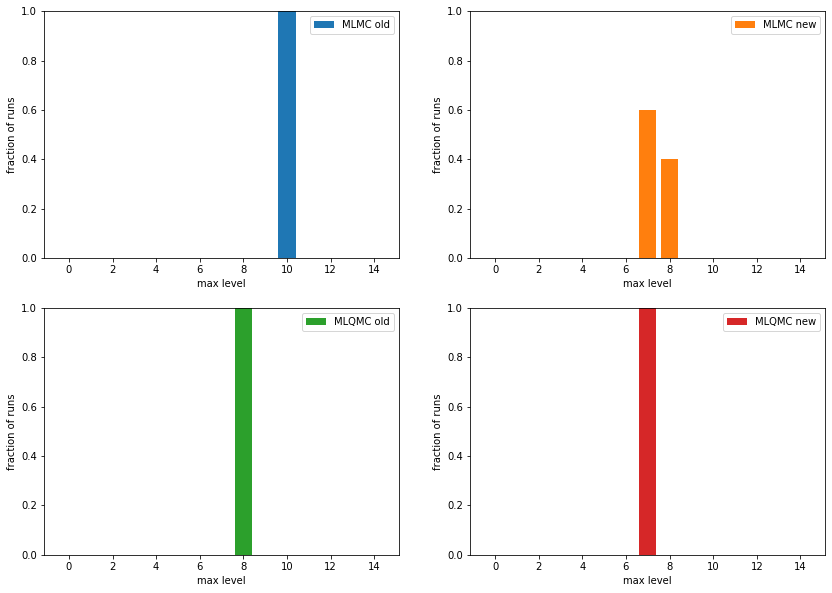

In [11]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1); plt.bar(range(15), max_levels[0], label="MLMC old", color="C0"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,2); plt.bar(range(15), max_levels[1], label="MLMC new", color="C1"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,3); plt.bar(range(15), max_levels[2], label="MLQMC old", color="C2"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,4); plt.bar(range(15), max_levels[3], label="MLQMC new", color="C3"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend();